# Clipping vs Sampling in iDP-SGD

## Define Setup


In [13]:
## Load Imports

from opacus_new.accountants import RDPAccountant

from types import SimpleNamespace
from tqdm import tqdm
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Secure RNG turned off.*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [14]:

from dp_accounting.pld import common, privacy_loss_distribution, privacy_loss_mechanism
from dp_accounting.pld.accountant import get_smallest_parameter

def get_max_sampling_prob_for_gaussian_noise(
    privacy_parameters: common.DifferentialPrivacyParameters,
    noise_multiplier: float,
    num_queries: int = 1,
    sensitivity: int = 1
) -> float:
    """Finds the largest sampling probability for a desired privacy guarantee
    of the subsampled Gaussian mechanism, given a fixed noise multiplier.

    This function leverages the `get_smallest_parameter` from the `dp_accounting`
    library. Since `get_smallest_parameter` finds the smallest value for which a
    privacy condition is met, and a larger sampling probability *worsens* privacy,
    we search for `1 - sampling_prob`. As `1 - sampling_prob` increases,
    `sampling_prob` decreases, which *improves* privacy. This aligns with the
    assumption of `get_smallest_parameter`.

    Args:
        privacy_parameters: The desired (epsilon, delta) privacy guarantee.
        noise_multiplier: The standard deviation of the Gaussian noise (sigma).
        num_queries: Number of times the mechanism will be invoked.
        sensitivity: The l2 sensitivity of each query.

    Returns:
        The largest sampling probability (q) for which the Poisson subsampled
        Gaussian mechanism with the specified noise_multiplier and q, when
        applied the given number of times, satisfies the desired privacy
        guarantee. Returns 0.0 if no such probability can be found (e.g.,
        if the noise is too low for any non-zero sampling probability).

    Raises:
        RuntimeError if a suitable sampling probability cannot be found
        within the search bounds.
    """

    def privacy_loss_distribution_constructor_for_sampling_prob(search_param_inverse: float):
        """
        Constructs the PrivacyLossDistribution using the current 'search_param_inverse'.
        This 'search_param_inverse' value corresponds to 1 - sampling_prob.
        """
        # Convert the search_param_inverse back to the actual sampling_prob
        # It's important to clamp the value to [0.0, 1.0] due to potential
        # floating-point inaccuracies during binary search, ensuring valid input
        # for from_gaussian_mechanism.
        actual_sampling_prob = max(1e-15, min(1.0, 1.0 - search_param_inverse))

        # Us ce the fixed noise_multiplier foronstructing the PLD.
        # The 'parameter' argument to from_gaussian_mechanism is the noise standard deviation.
        return privacy_loss_distribution.from_gaussian_mechanism(
            standard_deviation=noise_multiplier,
            sensitivity=sensitivity,
            # The value_discretization_interval is a heuristic to ensure sufficient
            # precision in the privacy loss distribution approximation.
            value_discretization_interval=min(
                1e-3, 0.1 * privacy_parameters.epsilon / num_queries
            ),
            sampling_prob=actual_sampling_prob
        )

    # The search space for 'search_param_inverse' is [0.0, 1.0].
    # A 'search_param_inverse' of 0.0 means sampling_prob = 1.0 (most privacy loss).
    # A 'search_param_inverse' of 1.0 means sampling_prob = 0.0 (least privacy loss).
    # We are looking for the *smallest* 'search_param_inverse' that satisfies
    # the privacy requirements, which will give us the *largest* 'sampling_prob'.
    search_parameters = common.BinarySearchParameters(0.0, 1.0)

    # Call get_smallest_parameter to find the smallest 'search_param_inverse'
    # that satisfies the privacy budget.
    param_found_inverse = get_smallest_parameter(
        privacy_parameters,
        num_queries,
        privacy_loss_distribution_constructor_for_sampling_prob,
        search_parameters
    )

    if param_found_inverse is None:
        # If no parameter was found by the binary search, it means even with
        # sampling_prob = 0.0 (corresponding to search_param_inverse = 1.0,
        # which offers the best privacy for a fixed noise), the desired
        # privacy budget could not be met. This typically indicates that the
        # provided noise_multiplier is too low for the given privacy requirements.
        raise RuntimeError(
            f"Could not find a suitable sampling probability for "
            f"noise_multiplier={noise_multiplier} and privacy_parameters="
            f"({privacy_parameters.epsilon}, {privacy_parameters.delta}). "
            f"Consider increasing the noise_multiplier or relaxing privacy requirements."
        )

    # Convert the found 'search_param_inverse' back to the actual sampling_prob.
    result_sampling_prob = 1.0 - param_found_inverse

    # Ensure the final result is within valid bounds [0, 1]. This guards against
    # minor floating-point anomalies that might push the value slightly outside.
    return max(0.0, min(1.0, result_sampling_prob))

# privacy_parameters_instance = common.DifferentialPrivacyParameters(epsilon=1.0, delta=1e-5)
# num_queries = 1000
# noise_multiplier = 2.2
# sensitivity = 1

# max_sampling_prob = get_max_sampling_prob_for_gaussian_noise(
#     privacy_parameters=privacy_parameters_instance,
#     noise_multiplier=noise_multiplier,
#     num_queries=num_queries,
#     sensitivity=sensitivity
# )
# print(f"Maximum sampling probability for the given parameters: {max_sampling_prob:.4f}")

In [15]:
from dp_accounting.pld.accountant import get_smallest_subsampled_gaussian_noise
from typing import List
from numpy import ndarray
import numpy as np

MAX_SIGMA = 1e3
MAX_Q = 1.0

def get_sample_rate(
    target_epsilon: float,
    target_delta: float,
    noise_multiplier: float,
    steps: int,
) -> float:
    max_sampling_prob = get_max_sampling_prob_for_gaussian_noise(
        privacy_parameters=common.DifferentialPrivacyParameters(epsilon=target_epsilon, delta=target_delta),
        noise_multiplier=noise_multiplier,
        num_queries=steps,
        sensitivity=1)
    return max_sampling_prob


def get_sample_rates(
    ratios: List[float],
    target_epsilons: List[float],
    target_delta: float,
    default_sample_rate: float,
    steps: int,
    precision: float = 0.001,
) -> (float, ndarray):
    r"""
    Computes via nested binary search the sampling frequency q for each privacy
    group to reach a total budget of (target_epsilon, target_delta) at the end
    of epochs, with a given default_sample_rate.
    Args:
        ratios: relative size of each privacy group within the training dataset
        target_epsilons: the privacy budget's epsilon for each privacy group
        target_delta: the privacy budget's delta
        default_sample_rate: sampling frequency to achieve expected_batch_size
        steps: number of steps to run
        accountant: accounting mechanism used to estimate epsilon
        precision: relation between limits of binary search interval
    Returns:
        The noise level sigma, and each a sampling frequency q for each privacy
        group to ensure privacy budgets of target_epsilons with target_delta
    """


    n_groups = len(list(ratios))
    ratios = np.asarray(ratios)
    sigma_low, sigma_high = 1e-5, 1e-3

    min_target_eps = min(target_epsilons)
    sigma_high = get_smallest_subsampled_gaussian_noise(
        privacy_parameters=common.DifferentialPrivacyParameters(min_target_eps, target_delta),
        num_queries=steps,
        sensitivity=1,
        sampling_prob=default_sample_rate
    )
    q_mean = MAX_Q
    qs = np.array([q_mean] * n_groups, dtype=np.float32)
    while sigma_low / sigma_high < 1 - precision:
        # print(f"Searching for sigma in [{sigma_low:.4f}, {sigma_high:.4f}]")
        sigma = (sigma_high + sigma_low) / 2
        q_mean = 0
        for group, target_epsilon in enumerate(target_epsilons):
            try:
                q = get_sample_rate(
                    target_epsilon=target_epsilon,
                    target_delta=target_delta,
                    noise_multiplier=sigma,
                    steps=steps,
                )
                qs[group] = q
                q_mean += q * ratios[group]
                if q_mean > default_sample_rate:
                    sigma_high = sigma
                    break
            except ValueError:
                continue
        q_mean = sum(qs * ratios)
        if q_mean > default_sample_rate:
            sigma_high = sigma
        else:
            sigma_low = sigma
    return sigma_high, list(qs)




In [16]:
def get_noise_multiplier(
    *,
    target_epsilon: float,
    target_delta: float,
    sample_rate: float,
    steps: int,
) -> float:
    return get_smallest_subsampled_gaussian_noise(
        privacy_parameters=common.DifferentialPrivacyParameters(
            epsilon=target_epsilon,
            delta=target_delta,
        ),
        num_queries=steps,
        sensitivity=1,
        sampling_prob=sample_rate,
    )


def get_noise_multipliers(
    target_epsilons: List[float],
    target_delta: float,
    sample_rate: float,
    steps: int,
) -> List[float]:
    r"""
    Computes via binary search the noise_multipliers for each privacy group to
    reach a total budget of (target_epsilon, target_delta) at the end of epochs,
    with a given sample_rate.
    Args:
        target_epsilons: the privacy budget's epsilon for each privacy group
        target_delta: the privacy budget's delta
        sample_rate: sampling frequency to achieve expected_batch_size
        steps: number of steps to run
        accountant: accounting mechanism used to estimate epsilon
        precision: relation between limits of binary search interval
    Returns:
        The noise level sigma for each privacy group to ensure privacy
        budgets of target_epsilons with target_delta
    """
    return [get_noise_multiplier(
        target_epsilon=budget,
        target_delta=target_delta,
        sample_rate=sample_rate,
        steps=steps,
    ) for budget in target_epsilons]

def get_avg_noise_and_clipping(noise_multipliers, ratios, default_max_grad_norm=1.0):
    average_noise_multiplier = sum(np.asarray(noise_multipliers)
                                    * np.asarray(ratios))
    clip_scalars = average_noise_multiplier / np.asarray(noise_multipliers)
    max_grad_norms = default_max_grad_norm * clip_scalars
    return average_noise_multiplier, list(max_grad_norms)



In [17]:

def make_private(target_epsilons, target_delta, ratios, default_sample_rate, steps, individualize):
    if individualize == 'clipping':
        sigmas = get_noise_multipliers(
            target_epsilons=target_epsilons,
            target_delta=target_delta,
            sample_rate=default_sample_rate,
            steps=steps
        )
        average_noise_multiplier, max_grad_norms = get_avg_noise_and_clipping(sigmas, ratios)
        return{
            "budgets": list(target_epsilons),
            "max_grad_norms": list(max_grad_norms),
            "sample_rate": [default_sample_rate] * len(list(target_epsilons)),
            "noise_multiplier": [average_noise_multiplier] * len(list(target_epsilons))
        }
    elif individualize == 'sampling':
        sigma, sample_rates = get_sample_rates(
            ratios=ratios,
            target_epsilons=target_epsilons,
            target_delta=target_delta,
            default_sample_rate=default_sample_rate,
            steps=steps
        )
        return{
            "budgets": list(target_epsilons),
            "max_grad_norms": [1.0] * len(list(target_epsilons)),
            "sample_rate":list(sample_rates),
            "noise_multiplier":[sigma] * len(list(target_epsilons))
        }
    else:
        return

In [18]:
from opacus_new.accountants.gdp import GaussianAccountant
from opacus_new.accountants.rdp import RDPAccountant
def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    def compute_epsilon(noise_multiplier, delta, iterations, sampling_rate, clipping_norm):
        accountant = RDPAccountant()
        for _ in range(int(iterations)):
            accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
        return accountant.get_epsilon(delta)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = compute_epsilon(noise_multiplier, delta, iterations, sampling_rate, clipping_norm)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

## Define Experiment

In [ ]:
import os
import json
import hashlib
import pickle

target_delta = 1e-5
overwrite = True
deltas = np.logspace(-8, -1, num=50)
privacy_group_1 = np.linspace(1, 5, num=4)
privacy_group_2 = np.linspace(1, 5, num=1)
portion_size_var = np.linspace(0.05, 0.95, num=5)
default_sample_rate = 0.001 # corresponds to batches of 64 in 640 samples
n_steps = 10000

## Log data and Load (if) existing data

In [20]:
## Load existing results if available

config = {
    "privacy_group_1": privacy_group_1.tolist(),
    "privacy_group_2": privacy_group_2.tolist(),
    "portion_size_var": portion_size_var.tolist(),
    "default_sample_rate": default_sample_rate,
    "n_steps": n_steps,
    "deltas": deltas.tolist()
}

# Generate a unique hash for the config
config_str = json.dumps(config, sort_keys=True)
config_hash = hashlib.md5(config_str.encode()).hexdigest()
folder_name = f"./experiments/experiment_{config_hash}"

# Create folder if it doesn't exist, else load data.pkl if present
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    config_path = os.path.join(folder_name, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=2)
    sampling_df = None
    clipping_df = None
else:
    config_path = os.path.join(folder_name, "config.json")
    sampling_df_path = os.path.join(folder_name, "sampling_df.pkl")
    clipping_df_path = os.path.join(folder_name, "clipping_df.pkl")
    if os.path.exists(sampling_df_path):
        with open(sampling_df_path, "rb") as f:
            sampling_df = pickle.load(f)
    else:
        sampling_df = None
    if os.path.exists(clipping_df_path):
        with open(clipping_df_path, "rb") as f:
            clipping_df = pickle.load(f)
    else:
        clipping_df = None



## Compute Epsilon - Delta curves

In [21]:
import concurrent.futures
import pandas as pd
from tqdm.notebook import tqdm as notebook_tqdm

sampling_results = []
clipping_results = []

def compute_task(priv_1, priv_2, target_delta, ratios, default_sample_rate, steps):
    import numpy as np  # Needed for worker processes
    results = []
    
    clipping_data = make_private([priv_1, priv_2], target_delta, ratios, default_sample_rate, steps, 'clipping')
    clipping_data_noise_multiplier = clipping_data['noise_multiplier']
    clipping_data_max_grad_norms = clipping_data['max_grad_norms']
    clipping_data_sample_rate = clipping_data['sample_rate']

    sampling_data = make_private([priv_1, priv_2], target_delta, ratios, default_sample_rate, steps, 'sampling')
    sampling_data_noise_multiplier = sampling_data['noise_multiplier']
    sampling_data_max_grad_norms = sampling_data['max_grad_norms']
    sampling_data_sample_rate = sampling_data['sample_rate']

    if len(clipping_data_noise_multiplier) == 1:
        clipping_data_noise_multiplier *= 2
    if len(clipping_data_max_grad_norms) == 1:
        clipping_data_max_grad_norms *= 2
    if len(clipping_data_sample_rate) == 1:
        clipping_data_sample_rate *= 2

    if len(sampling_data_noise_multiplier) == 1:
        sampling_data_noise_multiplier *= 2
    if len(sampling_data_max_grad_norms) == 1:
        sampling_data_max_grad_norms *= 2
    if len(sampling_data_sample_rate) == 1:
        sampling_data_sample_rate *= 2

    # sorting initialy needed for opacus_new
    # if priv_1 > priv_2:
    #     var_index = 0
    #     fixed_index = 1
    # else:
    var_index = 1
    fixed_index = 0

    for mode, data in [
        ("clipping_var", (clipping_data_noise_multiplier[var_index], clipping_data_sample_rate[var_index], clipping_data_max_grad_norms[var_index])),
        ("clipping_fixed", (clipping_data_noise_multiplier[fixed_index], clipping_data_sample_rate[fixed_index], clipping_data_max_grad_norms[fixed_index])),
        ("sampling_var", (sampling_data_noise_multiplier[var_index], sampling_data_sample_rate[var_index], sampling_data_max_grad_norms[var_index])),
        ("sampling_fixed", (sampling_data_noise_multiplier[fixed_index], sampling_data_sample_rate[fixed_index], sampling_data_max_grad_norms[fixed_index])),
    ]:
        epsilons, deltas_out = compute_epsilon_delta(
            noise_multiplier=data[0],
            deltas=deltas,
            iterations=n_steps,
            sampling_rate=data[1],
            clipping_norm=data[2]
        )
        type_label = "var" if "var" in mode else "fixed"
        for eps, delta in zip(epsilons, deltas_out):
            results.append({
                'privacy_fixed': priv_1,
                'privacy_var': priv_2,
                'portion': ratios[0],
                'type': type_label,
                'epsilon': eps,
                'delta': delta,
                'mode': mode
            })
    return results

# ret = compute_task(privacy_group_1[0], privacy_group_2[0], target_delta, [portion_size_var[0], 1-portion_size_var[0]], default_sample_rate, n_steps)
if (sampling_df is None or clipping_df is None) or overwrite:
    tasks = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for privacy_fixed in notebook_tqdm(privacy_group_1, desc="privacy_fixed", position=0, leave=True, disable=False):
            for privacy_var in privacy_group_2:
                for portion in portion_size_var:
                    # Submit each task
                    tasks.append(executor.submit(
                        compute_task, 
                        privacy_fixed, privacy_var, target_delta, [portion, 1-portion], default_sample_rate, n_steps
                    ))

        for future in notebook_tqdm(concurrent.futures.as_completed(tasks), total=len(tasks), desc="Aggregating results"):
            try:
                result = future.result()
                for entry in result:
                    if entry['mode'].startswith('clipping'):
                        clipping_results.append({k: v for k, v in entry.items() if k != 'mode'})
                    else:
                        sampling_results.append({k: v for k, v in entry.items() if k != 'mode'})
            except Exception as e:
                print(f"Task failed: {e}")

    sampling_df = pd.DataFrame(sampling_results)
    clipping_df = pd.DataFrame(clipping_results)
    sampling_df.to_pickle(os.path.join(folder_name, "sampling_df.pkl"))
    clipping_df.to_pickle(os.path.join(folder_name, "clipping_df.pkl"))
else:
    print("Already loaded existing results from disk.")

privacy_fixed:   0%|          | 0/4 [00:00<?, ?it/s]

Aggregating results:   0%|          | 0/160 [00:00<?, ?it/s]

In [22]:
print("Sampling DataFrame:")
print(sampling_df.head())

Sampling DataFrame:
   privacy_fixed  privacy_var  portion type   epsilon         delta
0       3.666667          5.0     0.85  var  6.918187  1.000000e-08
1       3.666667          5.0     0.85  var  6.853689  1.389495e-08
2       3.666667          5.0     0.85  var  6.788507  1.930698e-08
3       3.666667          5.0     0.85  var  6.722719  2.682696e-08
4       3.666667          5.0     0.85  var  6.656196  3.727594e-08


## Plots

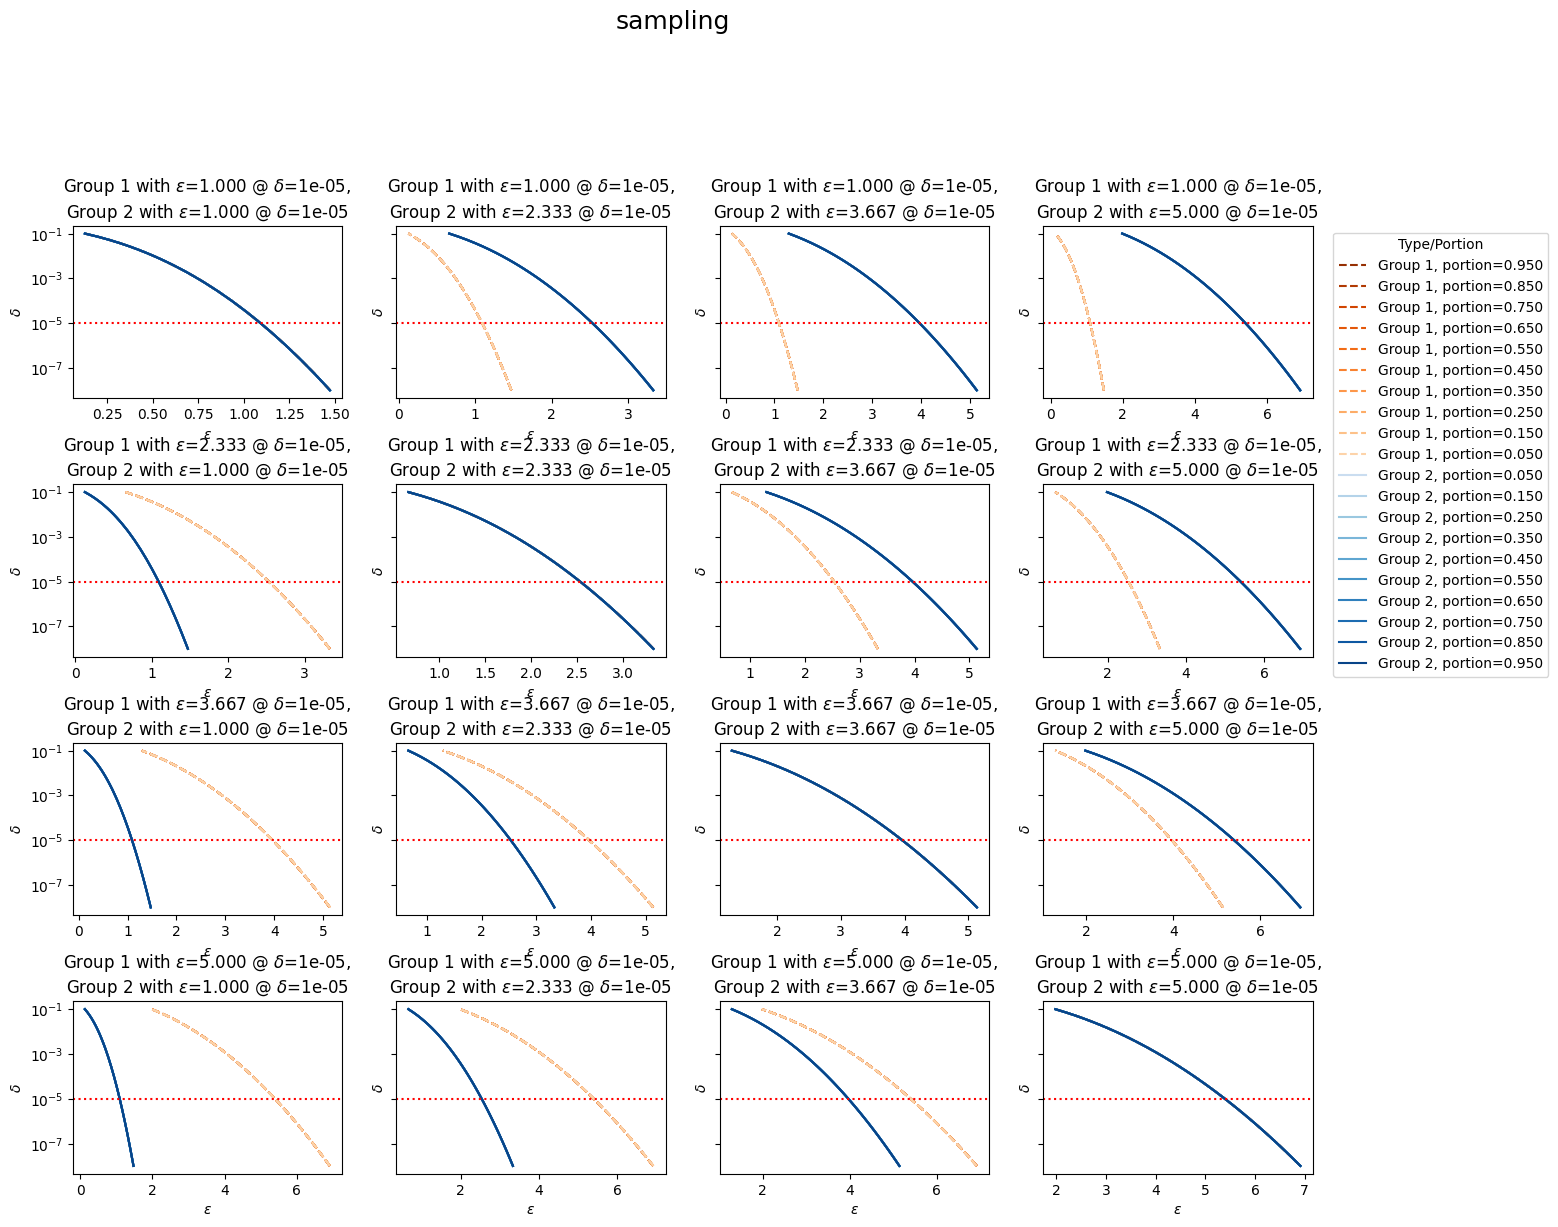

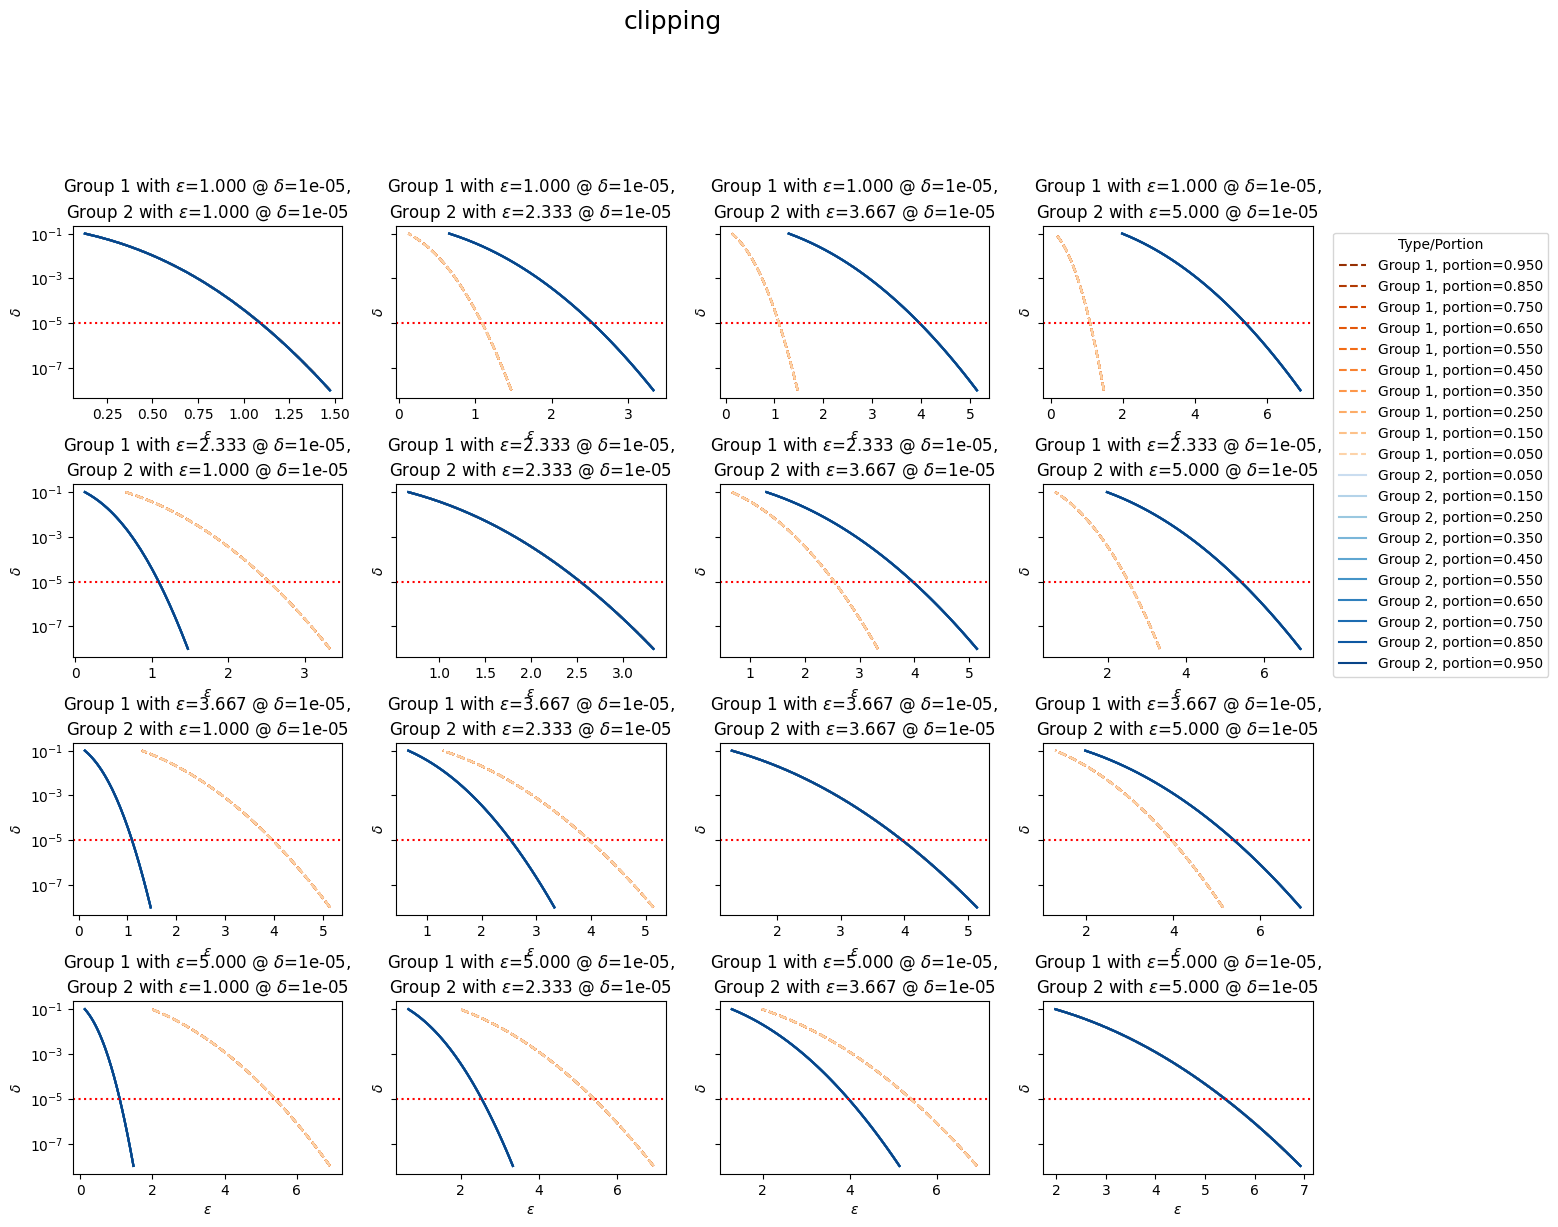

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_together(df, name_extension=""):
    unique_privacy_fixed = np.sort(df['privacy_fixed'].unique())
    unique_privacy_var = np.sort(df['privacy_var'].unique())
    unique_portion = np.sort(df['portion'].unique())

    n = len(unique_privacy_fixed)
    m = len(unique_privacy_var)

    # Define two base colors for "var" and "fixed"
    base_color_var = sns.color_palette("Blues", n_colors=len(unique_portion)+2)[2:]
    base_color_fixed = sns.color_palette("Oranges", n_colors=len(unique_portion)+2)[2:][::-1]

    # Plot separated by "type" (var/fixed)
    fig, axes = plt.subplots(n, m, figsize=(4*m, 3*n), sharex=False, sharey=True)
    for i, pf in enumerate(unique_privacy_fixed):
        for j, pv in enumerate(unique_privacy_var):
            ax = axes[i, j] if n > 1 and m > 1 else (axes[j] if n == 1 else axes[i])
            df_sub = df[(df['privacy_fixed'] == pf) & (df['privacy_var'] == pv)]
            for t, style in enumerate(['fixed', 'var']):
                color_list = base_color_var if style == 'var' else base_color_fixed
                for k, portion in enumerate(unique_portion):
                    df_line = df_sub[(df_sub['portion'] == portion) & (df_sub['type'] == style)]
                    portion_label = 1 - portion if style == "fixed" else portion
                    if not df_line.empty:
                        df_line = df_line.sort_values('delta')
                        # Swap x and y: x='epsilon', y='delta'
                        if not (style == 'var' and portion == 0.0):
                            ax.plot(df_line['epsilon'], df_line['delta'],
                                    label=f'{"Group 1" if style=="fixed" else "Group 2"}, portion={portion_label:.3f}',
                                    color=color_list[k], linestyle='-' if style == 'var' else '--')
            # Add horizontal line at args.target_delta (now y-axis)
            ax.axhline(target_delta, color='red', linestyle=':', label='target_delta' if (i == 0 and j == 0) else None)
            ax.set_yscale('log')
            ax.set_xlabel(r'$\epsilon$')
            ax.set_ylabel(r'$\delta$')
            ax.set_title(f'Group 1 with $\epsilon$={pf:.3f} @ $\delta$={target_delta},\nGroup 2 with $\epsilon$={pv:.3f} @ $\delta$={target_delta}')
            if i == 0 and j == m-1:
                ax.legend(title='Type/Portion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.suptitle(str(name_extension), fontsize=18)
    plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.5, wspace=0.2)
    plt.show()
    # Save the figure with extra space for the legend
    fig.savefig(f"{folder_name}/combined_{name_extension}.png", bbox_inches='tight')

plot_together(sampling_df, "sampling")
plot_together(clipping_df, "clipping")

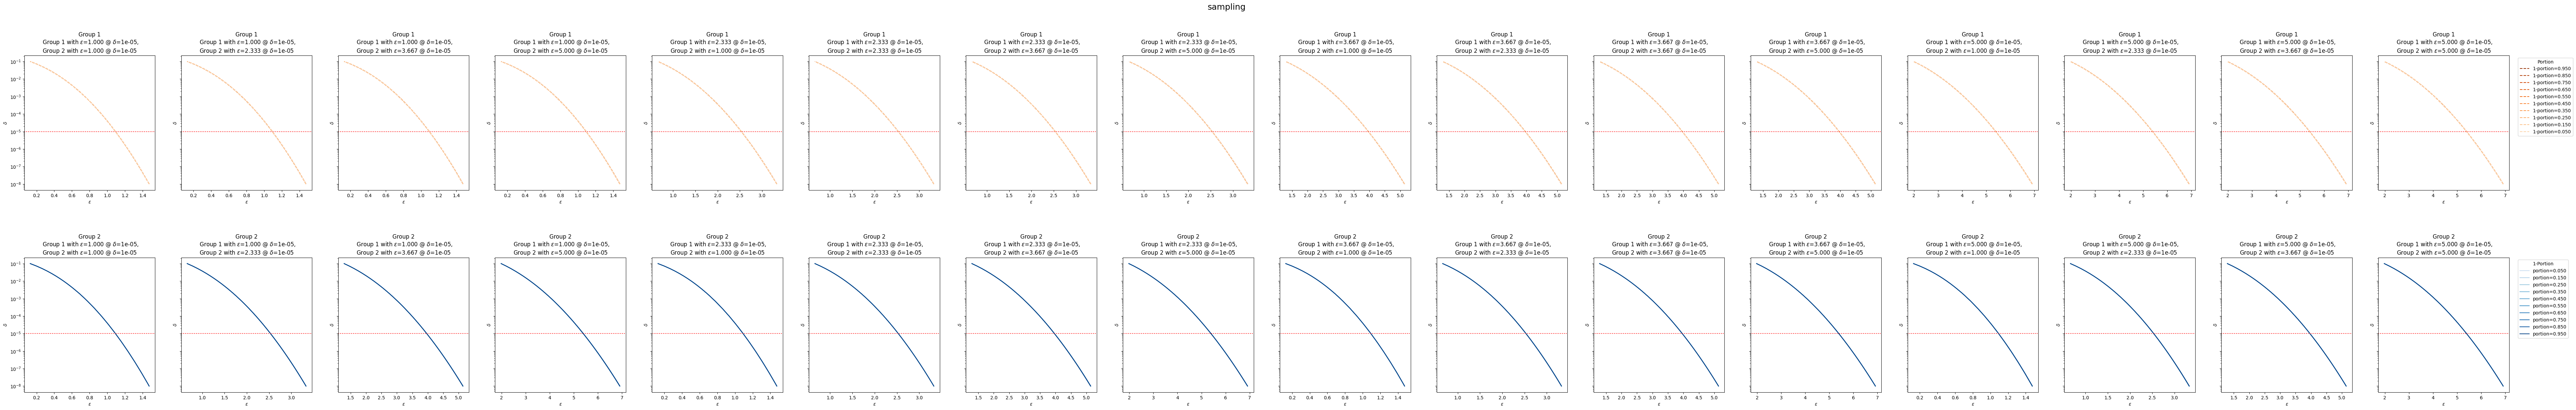

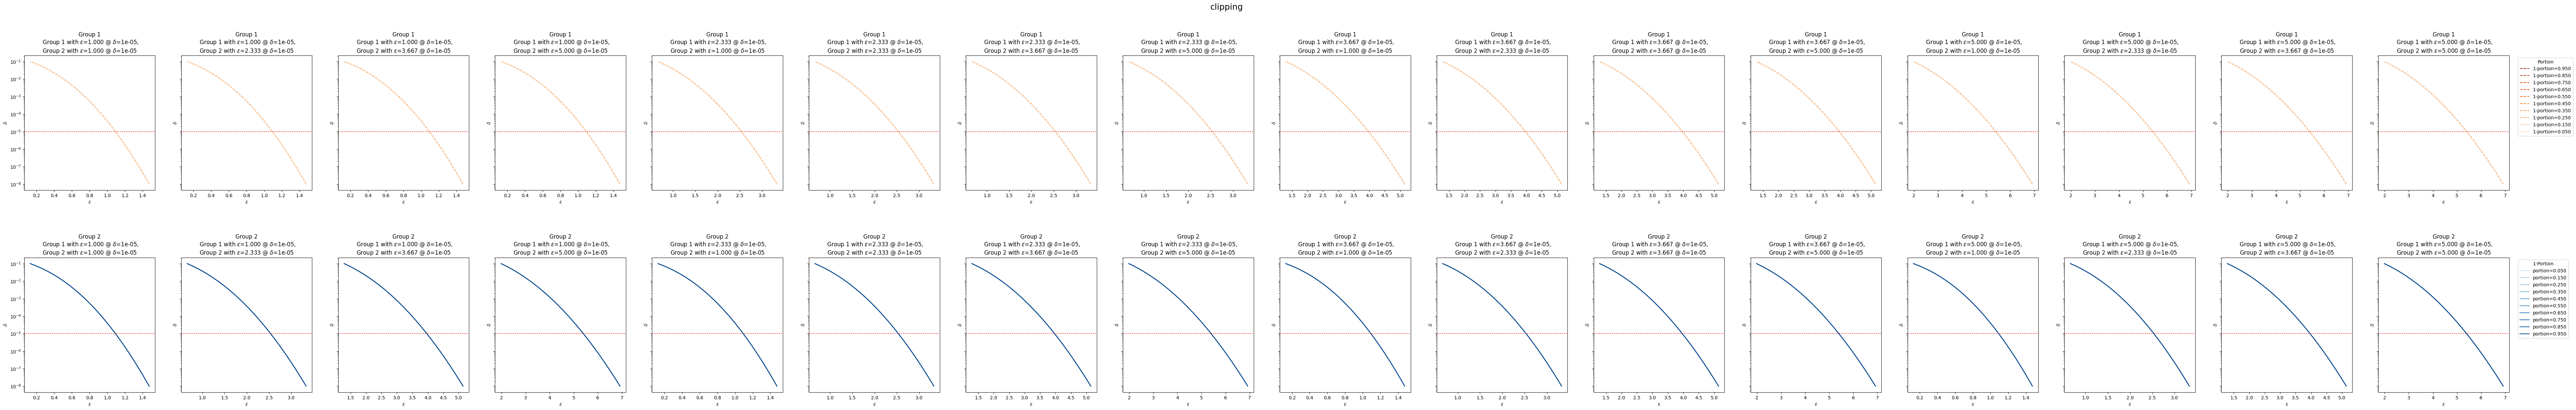

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_separate(df, name_extension=""):
    # Get unique values for grid dimensions
    unique_privacy_fixed = np.sort(df['privacy_fixed'].unique())
    unique_privacy_var = np.sort(df['privacy_var'].unique())
    unique_portion = np.sort(df['portion'].unique())

    n = len(unique_privacy_fixed)
    m = len(unique_privacy_var)
    n_panels = n * m

    # Calculate grid shape to be as square as possible
    ncols = math.ceil(n_panels)
    nrows = math.ceil(2)

    # Define two base colors for "var" and "fixed"
    base_color_var = sns.color_palette("Blues", n_colors=len(unique_portion)+2)[2:]
    base_color_fixed = sns.color_palette("Oranges", n_colors=len(unique_portion)+2)[2:][::-1]

    # Create a 2-row grid: row 0 for 'var', row 1 for 'fixed'
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows), sharex=False, sharey=True)

    for row, style in enumerate(['fixed', 'var']):
        color_list = base_color_var if style == 'var' else base_color_fixed
        for i, pf in enumerate(unique_privacy_fixed):
            for jdx, pv in enumerate(unique_privacy_var):
                ax_idx = i * m + jdx
                ax = axes[row, ax_idx]
                df_sub = df[(df['privacy_fixed'] == pf) & (df['privacy_var'] == pv) & (df['type'] == style)]
                for k, portion in enumerate(unique_portion):
                    df_line = df_sub[(df_sub['portion'] == portion)]
                    if not df_line.empty:
                        df_line = df_line.sort_values('delta')
                        label = (f'portion={portion:.3f}' if style == 'var'
                                else f'1-portion={1-portion:.3f}')
                        # Swap x and y: x='epsilon', y='delta'
                        if not (style == 'var' and portion == 0.0):
                            ax.plot(df_line['epsilon'], df_line['delta'],
                                    label=label,
                                    color=color_list[k], linestyle='-' if style == 'var' else '--')
                # Add horizontal line at args.target_delta (now y-axis)
                ax.axhline(target_delta, color='red', linestyle=':', label='target_delta' if (row == 0 and ax_idx == 0) else None)
                ax.set_yscale('log')
                ax.set_ylabel(r'$\delta$')
                ax.set_xlabel(r'$\epsilon$')
                ax.set_title(f'{"Group 1" if style=="fixed" else "Group 2"}\n Group 1 with $\epsilon$={pf:.3f} @ $\delta$={target_delta},\nGroup 2 with $\epsilon$={pv:.3f} @ $\delta$={target_delta}')
                if row == 0 and ax_idx == n_panels-1:
                    ax.legend(title='Portion', bbox_to_anchor=(1.05, 1), loc='upper left')
                if row == 1 and ax_idx == n_panels-1:
                    ax.legend(title='1-Portion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.suptitle(str(name_extension), fontsize=18)
    plt.subplots_adjust(top = 0.85, bottom=0.01, hspace=0.5, wspace=0.2)
    plt.show()
    fig.savefig(f"{folder_name}/separate_{name_extension}.png", bbox_inches='tight')

plot_separate(sampling_df, "sampling")
plot_separate(clipping_df, "clipping")
